# Chapter 4: Vibrational Motion
Prof. Eugene DePrince, Florida State University, and Prof. Jay Foley, UNC Charlotte

In the previous notebook, we discussed quantum mechanical problems involving translational motion: the free-particle, the particle-in-a-box model, the finite square well potential model, and tunneling through a one-dimensional potential energy barrier. In this notebook, we continue exploring model problems, with a focus, this time, on vibrational motion. In particular, we will find analytic solutions the Schrödinger equation for the (one-dimensional) quantum harmonic oscillator model, which captures the main qualitative features of vibrational motion in molecular systems. 

## The Harmonic Potential

A harmonic oscillator is a system that, when displaced from its equilibrium position, experiences a harmonic restoring force, which is proportional to the displacement. In one dimension, this force would be

$$ \begin{align}
F_x = -k (x - x_e)
\end{align}$$

where $x - x_e$ is the displacement from the equilibrium position, $x_e$, and $k$ is the proportionality constant, which is called the force constant. Recall that force and potential are related by

$$ \begin{align}
F_x = -\frac{d }{dx}V(x) = -k ( x - x_e)
\end{align}$$

Integrating this expression yields the potential

$$ \begin{align}
V(x) = \frac{1}{2} k (x - x_e)^2 + c
\end{align}$$

where $c$ is an arbitrary additive constant. This constant will not affect the solutions to the classical or quantum harmonic oscillator problems, but it will provide an arbitrary shift to the associated energies. For convenience, we choose $c = 0$, and we proceed with the potential

$$ \begin{align}
V(x) = \frac{1}{2} k (x - x_e)^2
\end{align}$$

Because the harmonic oscillator problem is a model for molecular vibrations, it will be illustrative to consider how this potential relates to one for an actual molecular system. For the sake of simlicity, let us take the molecule to be molecular hydrogen, H$_2$. Below, we will calculate the potential energy curve along the bond stretch coordinate for H$_2$ using one of the simplest procedures for finding approximate solutions to the electronic part of the Schrödinger equation, the Hartree-Fock approach. You can read more about Hartree-Fock theory in [this notebook](https://deprincelab.github.io/tutorials/jupyter_notebooks/hartree_fock/index.html). Specifically, we will use the unrestricted Hartree-Fock approach, as implemented in the [Psi4](https://psicode.org) electronic structure package, with the cc-pVDZ basis set.

In [1]:
import psi4
import numpy as np

# set molecule
mol = psi4.geometry("""
H
F 1 x
symmetry c1
""")   

# set some options for psi4
psi4.set_options({'basis': 'cc-pvdz',
                  'guess_mix': True,
                  'reference': 'rhf'})

# tell psi4 not to print any output to the screen
psi4.core.be_quiet()

# calculate the energy at different H-H separations, x
psi4_hf_potential = []
dx = 0.05
x = np.arange(0.4, 3.05, dx)
for i in range (0, len(x)):
    mol.x = x[i]
    en = psi4.energy('scf')
    psi4_hf_potential.append(en)

Molecule: geometry: Molecule is not complete, please use 'update_geometry'
                    once all variables are set.


In [2]:
import numpy as np
from pyscf import gto, scf # Import necessary modules

# set molecule
mol_template = """
H 0 0 0
F {} 0 0
"""

pyscf_hf_potential = []
dx = 0.05
x = np.arange(0.4, 3.05, dx)

for i in range(len(x)):
    current_x = x[i]

    # Redefine the molecule for each geometry
    # This is the PySCF equivalent of mol.x = x[i]
    mol = gto.M(
        atom=mol_template.format(current_x),
        basis='cc-pvdz',
        verbose=0,
        spin=0) # Keep output quiet for each step

    mf = scf.RHF(mol)
    mf.kernel()

    # Extract the energy
    en = mf.e_tot
    pyscf_hf_potential.append(en)


Now, let us visualize this potential (shifted so that the minimum value is zero)

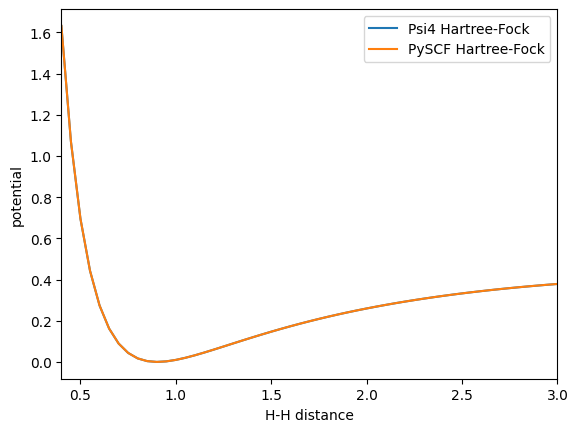

In [3]:
# minimum energy
V_e_psi4 = min(psi4_hf_potential)
V_e_pyscf = min(pyscf_hf_potential)
assert np.isclose(V_e_psi4, V_e_pyscf)

# shift potential so the minimum value is zero
psi4_hf_potential = np.array(psi4_hf_potential) - V_e_psi4
pyscf_hf_potential = np.array(pyscf_hf_potential) - V_e_pyscf

import matplotlib.pyplot as plt

plt.figure()
plt.plot(x, psi4_hf_potential, label='Psi4 Hartree-Fock')
plt.plot(x, pyscf_hf_potential, label='PySCF Hartree-Fock')
plt.xlim(x[0], x[-1])
#plt.ylim(0, 0.2)
plt.ylabel('potential')
plt.xlabel('H-H distance')
plt.legend()
plt.show()

Near the equilibrium H-H distance, the potential in which the nuclei live looks harmonic, i.e., it could be approximated by a quadratic function. How can we extract an appropriate force constant, $k$, from this potential? Well, if 

$$ \begin{align}
V(x) = \frac{1}{2} k(x-x_e)^2
\end{align}$$

where $x$ is the H-H distance, and $x_e$ is the equilibrium H-H distance, then 

$$ \begin{align}
k = \frac{d^2}{dx^2} V(x) 
\end{align}$$

So, we take $k$ to be the second derivative of the potential with respect to the H-H distance, evaluated at the equilibrium geometry. The second derivative of the potential can be calculated numerically, via the centered [finite difference](https://en.wikipedia.org/wiki/Finite_difference) formula

$$\begin{align}
k \approx \frac{V(x_e + h) - 2 V(x_e) + V(x_e - h)}{h^2} 
\end{align}$$

where $h$ is a displacement from the equilbrium H-H distance, $x_e$. Here, we calculate $k$ in this way and visualize the harmonic and Hartree-Fock potentials together.

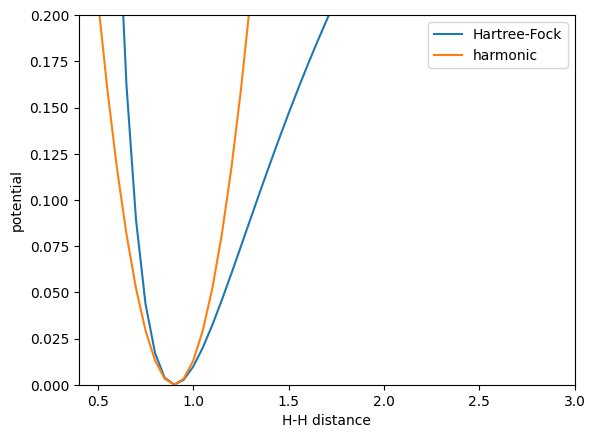

In [4]:
# equilbirum bond length
hf_potential = np.copy(pyscf_hf_potential)
idx = np.argmin(hf_potential)
x_e = x[idx]

# k = d^2 V(x) / dx^2
k = (hf_potential[idx+1] - 2.0 * hf_potential[idx] + hf_potential[idx-1]) / dx**2

# harmonic potential
harmonic = 0.5 * k * (x-x_e)**2

plt.figure()
plt.plot(x, hf_potential, label='Hartree-Fock')
plt.plot(x, harmonic, label='harmonic')
plt.xlim(x[0], x[-1])
plt.ylim(0, 0.2)
plt.ylabel('potential')
plt.xlabel('H-H distance')
plt.legend()
plt.show()

Clearly these potentials have some major qualitative differences, the most obvious of which is that the Hartree-Fock potential tends to some constant value in the limit of dissociation, whereas the harmonic potential does not. Indeed, for the harmonic potential, $V(x)$, 

$$ \begin{align}
\lim_{x\to\infty} V(x) = \infty 
\end{align}$$

Nonetheless, the harmonic potential does a reasonable job of approximating the Hartree-Fock one near equilibrium. Hence, we consider the quantum harmonic oscillator model to be useful for describing low-energy vibrational states only. Higher-energy states will be poorly described by this model. 

## One-Dimensional Classical Harmonic Oscillator

Now, we seek solultions to the classical harmonic oscillator problem. In this case, let us assume that the equilibrium position, $x_e = 0$, and note that we would like to solve for the position as a function of time, $x(t)$. Recall that the harmonic restoring force is linear in the displacement, 

$$ \begin{align}
F_x = -k x(t)
\end{align}$$

Classically, we can find an analytic form for how the displacement evolves over time with the help of Newton's second law,

$$\begin{align}
F_x = m a_x(t)
\end{align}$$

where the acceleration of the oscillator, $a_x(t)$, is the second time derivative of the position, i.e.,

$$\begin{align}
a_x(t) = \frac{d^2}{dt^2} x(t)
\end{align}$$

So, we seek a solution to the differential equation

$$ \begin{align}
m \frac{d^2}{dt^2} x(t) = -k x(t)
\end{align}$$ 

which has a general solution

$$ \begin{align}
x(t) = C\text{sin}\left ( \left [ k/m \right ]^{1/2} t \right ) + D \text{cos}\left( \left [ k/m \right ]^{1/2} t \right )
\end{align}$$

or 

$$\begin{align}
x(t) = A\text{sin}\left ( \left [ k/m \right ]^{1/2} t + B \right ) 
\end{align}$$

where $B$ represents a phase shift. This solution tells us that harmonic motion is sinusoidal, which we can visualize using the following code. In this case, let us take some arbitrary values for $k$, $m$, $A$, and $B$, which are all specified below. In addition to visualizing the position, $x(t)$, we will also plot the kinetic energy, $T$, and potential energy, $V$ as functions of time. 

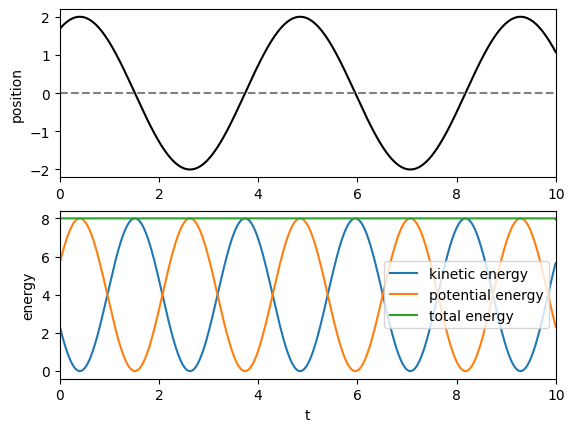

In [5]:
dt = 0.01
t = np.arange(0, 10.01, dt)

k = 4.0
m = 2.0
B = 1.0
A = 2.0

# position, x(t)
x_t = A * np.sin(np.sqrt(k/m) * t + B)

# calculate velocicty from the position using np.gradient
velocity = np.gradient(x_t, t)

# kinetic energy
T = 0.5 * m * velocity**2

# potential energy
V = 0.5 * k * x_t**2

# plot position
fig, axs = plt.subplots(2)
axs[0].plot(t, x_t, color = 'black')
axs[0].axhline(y=0.0, color='gray', linestyle='--')

axs[0].set_xlim(0, 10)
axs[0].set_ylabel('position')

# plot kinetic and potential energy
axs[1].plot(t, T, label = 'kinetic energy')
axs[1].plot(t, V, label = 'potential energy')
axs[1].plot(t, T + V, label = 'total energy')

axs[1].set_xlim(0, 10)
axs[1].set_ylabel('energy')
axs[1].set_xlabel('t')

plt.legend()
plt.show()

The displacement, $x(t)$, oscillates between $A$ and $-A$ with a frequency, $\nu$, 

$$ \begin{align}
\nu = \frac{1}{2\pi}  \left ( \frac{k}{m} \right )^{1/2}
\end{align}$$

It will be useful at times to also consider the *angular frequency*, $\omega$, which is related to $\nu$ by a factor of $2 \pi$:

$$ \begin{align}
\omega = 2 \pi \nu = \left ( \frac{k}{m} \right )^{1/2}
\end{align}$$

The kinetic and potential energy also oscillate in time, but their sum, the total energy, is constant in time. This result makes sense because the oscillator is not being driven, nor is it interacting with any sort of bath, so the total energy should be conserved. Note also that the frequency with which the the kinetic and potential energy oscillate is twice the frequency with which the position oscillates. This behavior reflects the symmetry of the potential, $V(x)$. For example, the potential energy should go to zero twice per single oscillation of the position, once as the oscillator moves past its equilibrium position in the $+x$ direction and again when it passes through equilibrium in the $-x$ direction. Similarly, the kinetic energy should go to zero twice per oscillation in the position, at the two **classical turning points**. 

The classical turning point is the point at which the potential energy is equal to the total energy and the kinetic energy is equal to zero. The term, turning point, refers to the fact that this is the point at which the oscillator stops moving and reverses direction. For the classical harmonic oscillator with 

$$ \begin{align}
x(t) = A\text{sin}\left ( \left [ k/m \right ]^{1/2} t + B \right ) 
\end{align}$$

the turning points are simply $-A$ and $A$. Let's visualize the classical turning points, total energy, and  harmonic potential together.

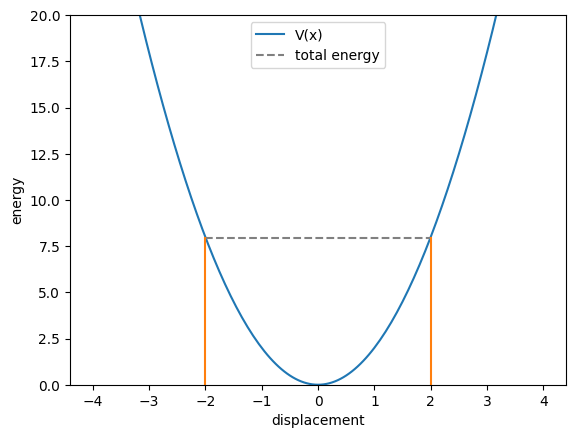

In [6]:
# total energy at time zero
energy = T[0] + V[0]

# turning points
x_max = A
x_min = -A
    
# harmonic potential. 
dx = 0.05
x = np.arange(-4, 4.05, dx)
harmonic = 0.5 * k * x**2

plt.figure()
plt.plot(x, harmonic, label='V(x)')

plt.plot([x_min, x_max], [energy, energy], color='gray', linestyle='--', label = 'total energy')
plt.plot([x_min, x_min], [0, energy], color = 'tab:orange', linestyle = '-')
plt.plot([x_max, x_max], [0, energy], color = 'tab:orange', linestyle = '-')

plt.ylim(0, 20)
plt.ylabel('energy')
plt.xlabel('displacement')
plt.legend()
plt.show()

Note that the classical harmonic oscillator will never be found with a displacement beyond the turning points. As we will find below, the situation will be different for the quantum harmonic oscillator.

## One-Dimensional Quantum Harmonic Oscillator

Now, we would like to consider the quantum mechanical treatment of the one-dimensional harmonic oscillator problem. Given the potential explored in the previous section, 

$$ \begin{align}
V(x) = \frac{1}{2} k x^2
\end{align}$$

the Hamiltonian has the form

$$ \begin{align}
\hat{H} = -\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + V(x)
\end{align}$$

$m$ represents the mass of the oscillator, and we have assumed that $x_e = 0$. Recall from the classical harmonic oscillator problem that the force constant is related to the frequency of oscillation as

$$\begin{align}
k = \frac{1}{2\pi}\left ( \frac{k}{m} \right )^{1/2}
\end{align}$$

so the potential can be expressed as

$$\begin{align}
V(x) = 2 m \nu^2 \pi^2 x^2
\end{align}$$

Now, it will be convenient to introduce a constant, $\alpha$, which is defined as

$$\begin{align}
\alpha = \frac{2 \pi \nu m}{\hbar}
\end{align}$$

so that the Hamiltonian can be expressed as

$$ \begin{align}
\hat{H} = -\frac{\hbar^2}{2m}\left ( \frac{d^2}{dx^2} - \alpha^2 x^2 \right )
\end{align}$$

As was the case for the translational problems explored in the previous notebook, this Hamiltonian is time-independent, so our goal is to find the eigenfunctions that satisfy the time-independent Schrödinger equation,

$$\begin{align}
\hat{H} \psi(x) = E \psi(x)
\end{align}$$

or 

$$\begin{align}
-\frac{\hbar^2}{2m}\left ( \frac{d^2}{dx^2} - \alpha^2 x^2 \right) \psi(x) = E \psi(x)
\end{align}$$

Rerranging this equation slightly gives us

$$\begin{align}
\frac{d^2}{dx^2} \psi(x) + \left (\frac{2 m E}{\hbar^2} - \alpha^2 x^2 \right )\psi(x) = 0 
\end{align}$$

Unfortunately, we can see that this differential equation is much more complicated than any that we have encountered so far, which is attributable to the fact that the potential depends the displacement, $x$. In order to solve this equation, we find a power series solution.

### Power Series Solution to the Schrödinger Equation

The basic idea of a power series solution to a differential equation is to assume that the function, in this case, the wave function, $\psi(x)$, can be expanded as a power series

$$ \begin{align}
\psi(x) = \sum_{n=0}^{\infty} a_n x^n = a_0 + a_1 x + a_2 x^2 + ...
\end{align}$$

This form can then be substituted back into the differential equation so that we can solve for the unknown expansion coefficients, $a_n$. Doing so, in this case, would lead to a three-term recursion relation amongst the coefficients. It turns out that a simpler, two-term recursion relation can be obtained by instead making a clever choice for the functional form of $\psi(x)$ before invoking the concept of the power series. Armed with the <b><font color='red'>i</font><font color='orange'>n</font><font color='yellow'>f</font><font color='green'>i</font><font color='blue'>n</font><font color='indigo'>i</font><font color='violet'>t</font><font color='red'>e</font> <font color='orange'>w</font><font color='yellow'>i</font><font color='green'>s</font><font color='blue'>d</font><font color='indigo'>o</font><font color='violet'>m</font></b> of already knowing the right answer, we will try

$$ \begin{align}
\psi(x) = e^{-\alpha x^2/2} f(x)
\end{align}$$

and expand $f(x)$ as a power series, rather than $\psi(x)$. So, we have

$$ \begin{align}
f(x) = \sum_{n=0}^\infty c_n x^n
\end{align}$$

and our task is to determine the coefficients, $c_n$. Let us begin by recognizing that the time-independent Schrödinger equation is a second-order differential equation, so we need to evaluate the second derivative of the wave function. The first derivative is

$$ \begin{align}
\psi^\prime(x) = -\alpha x e^{-\alpha x^2/2} f(x) + e^{-\alpha x^2/2} f^\prime(x)
\end{align}$$

and the second derivative is

$$ \begin{align}
\psi^{\prime\prime}(x) = e^{-\alpha x^2/2}\left [ -\alpha f(x) + \alpha^2 x^2 f(x) - 2\alpha x f^{\prime}(x) + f^{\prime\prime}(x) \right ]
\end{align}$$

Inserting $\psi(x)$ and $\psi^{\prime\prime}(x)$ into the Schrödinger equation yields

$$ \begin{align}
e^{-\alpha x^2/2}\left [ -\alpha f(x) + \alpha^2 x^2 f(x) - 2\alpha x f^{\prime}(x) + f^{\prime\prime}(x) \right ] + \left (\frac{2 m E}{\hbar^2} - \alpha^2 x^2 \right ) e^{-\alpha x^2/2} f(x) = 0 
\end{align}$$

which simplifies to

$$\begin{align}
f^{\prime\prime}(x) - 2\alpha x f^{\prime}(x) + \left (\frac{2 m E}{\hbar^2} - \alpha\right )  f(x) = 0 
\end{align}$$

Now, we must evaluate the first and scond derivative of $f(x)$. Recall

$$ \begin{align}
f(x) = \sum_{n=0}^{\infty} c_n x^n
\end{align}$$

so $f^{\prime}(x)$ is

$$ \begin{align}
f^{\prime}(x) &= \sum_{n = 1}^{\infty}n c_n x^{n-1} \\
&= \sum_{n = 0}^\infty n c_n x^{n-1}
\end{align}$$

where, in the second line, we note that the lower limit of the sum can be changed to zero without impacting the sum. The second derivative is

$$\begin{align}
f^{\prime\prime}(x) &= \sum_{n = 2} n(n-1) c_n x^{n-2}
\end{align}$$

By choosing a dummy index, $k = n-2$, we can adjust the summation limits so that they match those used in the first derivative expression

$$\begin{align}
f^{\prime\prime}(x) &= \sum_{k = 0} (k+2)(k+1) c_{k+2} x^k
\end{align}$$

or 

$$\begin{align}
f^{\prime\prime}(x) &= \sum_{n = 0} (n+2)(n+1) c_{n+2} x^n
\end{align}$$

Plugging these results back into 

$$ \begin{align}
f^{\prime\prime}(x) - 2\alpha x f^{\prime}(x) + \left (\frac{2 m E}{\hbar^2} - \alpha\right )  f(x) = 0 
\end{align}$$

yields

$$ \begin{align}
\sum_{n=0}^{\infty}  \left [ (n+2)(n+1) c_{n+2} - 2 \alpha n c_n + \left ( \frac{2mE}{\hbar^2} - \alpha \right ) c_n \right ] x^n = 0
\end{align}$$

Now, we note that the monomials, $x^n$, are linearly independent functions, which means that the polynomial in the above equation can only be satisfied for all values of $x$ if the coefficient in front of $x^n$ is zero, for all $n$. So we have

$$ \begin{align}
(n+2)(n+1) c_{n+2} + \left (  - 2 \alpha n + \frac{2mE}{\hbar^2} - \alpha \right ) c_n  = 0\text{, }\forall n
\end{align}$$

which leads to a two-term recursion relation

$$ \begin{align}
c_{n+2} = \frac{\alpha(2n+1) - 2mE/\hbar^2}{(n+1)(n+2)} c_n
\end{align}$$

### Applying Boundary Conditions

Having established the form of the wave function and the recursion relation for the coefficients in the power series expansion, we must now ask ourselves whether any restrictions need to be placed on the coefficients in order for the wave function to be well behaved. This exercise will be easiest if we regroup the terms in the power series slightly. First, let us assume that the coefficient $c_1$ is equal to zero. If this is the case, then all coefficients, $c_n$, with odd $n$ will also be zero, and the wave function will have the form

$$\begin{align}
\psi(x) &= e^{-\alpha x^2/2} \sum_{n = 0, 2, 4...}^{\infty} c_n x^n \\ 
&= e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l} x^{2l}
\end{align}$$

similarly, if $c_0 = 0$, then all coefficients, $c_n$, with even $n$ will also be zero, leading to

$$\begin{align}
\psi(x) &= e^{-\alpha x^2/2} \sum_{n = 1, 3, 5...}^{\infty} c_n x^n \\ 
&= e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l+1} x^{2l+1}
\end{align}$$

Now, a general form for the wave function could be expressed as a linear combination of these even and odd terms

$$ \begin{align}
\psi(x) = A e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l+1} x^{2l+1} + B e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l} x^{2l} 
\end{align}$$

Our task is not to determine the coefficients $A$, $B$, $c_0$, and $c_1$. To do so, we should ask ourselves how do these functions behave in the limit that $l$ becomes very large? Let us consider the ratio of two successive coefficients in the in the even series, $c_{2l+2}$ and $c_{2l}$:

$$ \begin{align}
\frac{c_{2l+2}}{c_{2l}} = \frac{\alpha + 4 \alpha l - 2mE/\hbar^2}{(2l+1))(2l+2)}
\end{align}$$

In the limit of large $l$, we have

$$\begin{align}
\lim_{l\to\text{large}} \frac{c_{2l+2}}{c_{2l}} = \frac{\alpha}{l}
\end{align}$$

Performing this exercise on the odd series leads to the same result. Again, armed with the <b><font color='red'>i</font><font color='orange'>n</font><font color='yellow'>f</font><font color='green'>i</font><font color='blue'>n</font><font color='indigo'>i</font><font color='violet'>t</font><font color='red'>e</font> <font color='orange'>w</font><font color='yellow'>i</font><font color='green'>s</font><font color='blue'>d</font><font color='indigo'>o</font><font color='violet'>m</font></b> of already knowing the right answer, let us attempt to find a Taylor series expansion that looks similar in the limit of large $l$. Consider the Taylor series expansion for the Gaussian function

$$\begin{align}
e^{\alpha x^2} &= \sum_{n=0} \frac{(\alpha x^2)^n}{n!} \\
&= 1 + \alpha x^2 + ... + \frac{\alpha^lx^{2l}}{l!} + \frac{\alpha^{l+1}x^{2l+1}}{(l+1)!}
\end{align}$$

Taking the ratio of the coefficients in the last two terms yields

$$ \begin{align}
\frac{\alpha^{l+1}l(l-1)(l-2)...}{\alpha^l(l+1) l (l-1)(l-2)...} = \frac{\alpha}{l+1}
\end{align}$$

and

$$\begin{align}
\lim_{l\to\text{large}} \frac{\alpha}{l+1} = \frac{\alpha}{l}
\end{align}$$

The conclusion we can draw is that, for large $l$, the power series expansion of $f(x)$ begins to look like the Gaussian function, $e^{\alpha x^2}$!

What consequences does this observation have for the wave function? Recall, we have

$$ \begin{align}
\psi(x) =  A e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l+1} x^{2l+1} + B e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l} x^{2l} 
\end{align}$$

Consider the limit as $x$ tends to infinity. In this case, $\psi(x)$ will be dominated by the large-$l$ terms, and, as $l$ gets large, each series begins to look like $e^{\alpha x^2}$. To a gross approximation, we have

$$\begin{align}
\lim_{x \to \infty} \psi(x) &\approx e^{-\alpha x^2/2} \left [A e^{\alpha x^2}  + B e^{\alpha x^2} \right ] \\
&\approx e^{\alpha x^2/2} \left [A  + B \right ]
\end{align}$$

Recall that $\alpha = 2\pi\nu m / \hbar > 0$ is a positive number, so

$$\begin{align}
\lim_{x \to \infty} \psi(x) = 0 
\end{align}$$

which clearly is not acceptable because this result implies that 

1. $\psi(x)$ would not be square integrable.
2. the probability of finding the oscillator infinitely far from equilibrium would be infinite.

Hence, we have discovered the boundary condition for this problem. 

Under what circumstances can we guarantee that $\psi(x)$ will not go to infinity as $x \to \infty$? The choice $A = B = 0$ would suffice, except that $|\psi(x)|^2=0$ for all $x$, which implies that there is zero probability of finding the oscillator at any displacement. This result does not make sense physically and is rejected. If either $A$ or $B$ are nonzero, then the power series expansion for $f(x)$ must truncate to avoid the wave function tending to infinity at large displacements. The way to accomplish this goal is to require that, for some coefficient $c_v$, the next coefficient in the series, $c_{v+2}$, must vanish. In this case, we would have

$$\begin{align}
c_{v+2} = 0 = \frac{\alpha ( 2 v + 1) - 2mE/\hbar^2}{(v+1)(v+2)} c_v
\end{align}$$

Solving for $E$ and using $\alpha = 2\pi \nu m / \hbar$ yields

$$\begin{align}
E_v = \hbar\omega\left ( v + \frac{1}{2} \right) = h\nu \left( v + \frac{1}{2} \right)
\end{align}$$

where we have added a subscript "$v$" to the energy to indicate that the energy of the state is determined by the vibrational quantum number, $v$. So, what have we learned?

1. The energy of the QHO is quantized, and $v$ is the quantum number. $v = 0, 1, 2, ...$ are allowed values for the quantum number.
2. Once again, the application of boundary conditions has led to the quantization of the energy.
3. The energy leves for a QHO are evenly spaced (by $\hbar \omega$ or $h\nu$).
4. If $v=0$ is allowed (it is), then they lowest energy is
   $$\begin{align}
   E_0 = \frac{1}{2} \hbar \omega = \frac{1}{2} h \nu
   \end{align}$$
   which is called the "zero-point" energy. Since there is no lower energy leven, the interpretation is that the energy of the QHO is non-zero, even at zero kelvin. 
   

### QHO Wave Functions

In the previous section, the solutions to the Schrödinger equation were given as a linear combination of polynomials involving either even and odd powers of $x$, i.e.,

$$ \begin{align}
\psi_v(x) = A e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l+1} x^{2l+1} + B e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l} x^{2l} 
\end{align}$$

where we have added a subscript, $v$, to denote the quantum number for the state. Now, it becomes clear that, in order for these functions to be well behaved, we should include only one of these sums, based on whether $v$ is even or odd. The reason is that, if, for example, $v$ is even, then the even series will truncate, but the odd series will not. Hence, for even $v,$ the coefficient $A$ must vanish. Similarly, if $v$ is odd, then the odd series will truncate, but the even one will not. Hence, for odd $v,$ the coefficient $B$ must vanish. In other words, an eigenfunction of the QHO Hamiltonian, $\psi_v(x)$ will consist of one of these sums, but not both. 

As an example, consider the state with $v = 2,$ where $A$ must be equal to zero. 

$$\begin{align}
\psi_2(x) = B \sum_{l=0}^\infty c_{2l} x^{2l} e^{-\alpha x^2/2}
\end{align}$$

What are the coefficients, $c_{2l}$?  Recall,

$$ \begin{align}
c_{n+2} = \frac{\alpha (2n+1) - 2mE/\hbar^2}{(n+1)(n+2)} c_n 
\end{align}$$

Given that

$$\begin{align}
\alpha = 2\pi \nu m / \hbar
\end{align}$$

and

$$\begin{align}
E = h \nu ( v + 1/2)
\end{align}$$

we can show that

$$\begin{align}
\frac{m E}{\hbar^2} = \alpha ( v + 1/2)
\end{align}$$

so the recursion relationship becomes

$$\begin{align}
c_{n+2} = \frac{2\alpha ( n + 1/2) - 2\alpha ( v + 1/2)}{(n+1)(n+2)} c_n
\end{align}$$

Now, it is clear that the numerator will vanish and the series will truncate when $n = v.$ So, for $v = 2$, we can assume that $c_0$ can be determined via normalization, and then we have

$$\begin{align}
c_2 &= \frac{2\alpha(0 - 2)}{(0+1)(0+2)}c_0 = -2\alpha c_0 \\
c_4 &= \frac{2\alpha(2 - 2)}{(2+1)(2+2)}c_2 = 0 \\
c_6 &= 0 \\
\text{etc.}
\end{align}$$

and

$$ \begin{align}
\psi_2(x) = B c_0 \left ( 1 - 2\alpha x^2 \right )e^{-\alpha x^2/2} 
\end{align}$$

We can absorb $B$ and $c_0$ into a single normalization constant, $N_2$

$$\begin{align}
\psi_2(x) = N_2 \left ( 1 - 2\alpha x^2 \right )e^{-\alpha x^2/2}
\end{align}$$

or, after normalization

$$\begin{align}
\psi_2(x) = \left ( \frac{\alpha}{4\pi} \right)^{1/4} \left ( 1 - 2\alpha x^2 \right )e^{-\alpha x^2/2}
\end{align}$$

In general, the wave function for state $v$ has the form


$$\begin{align}
\psi_v(x) = \left ( 2^v v! \right )^{-1/2} \left ( \frac{\alpha}{\pi} \right)^{1/4} e^{-\alpha x^2/2} H_v(\alpha^{1/2} x)
\end{align}$$

where $H_v$ represents a special polynomial function called a Hermite polynomial, the first few of which are tabulated here:


| $H_n(z)$ | symmetry |
|---|---|
| $H_0 = 1$ | even |
| $H_1 = 2z$ | odd |
| $H_2 = 4z^2-2$ | even |
| $H_3 = 8z^3 - 12z$ | odd |

Because the Gaussian part of the wave function, $e^{-\alpha x^2/2}$, is even in the displacement coordinate, the symmetry of the Hermite polynomials determines the overall symmetry of the wave function. Let us visualize the first few QHO wave functions using the built-in Hermite polynomial functionality in scipy library. For this excercise, we will use arbitrary values for the parameters, $\alpha$ and $m$, that are chosen for ease of visualization. 

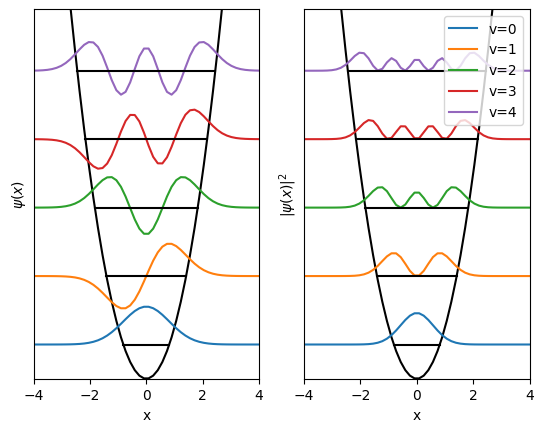

In [7]:
# for hermite polynomials
import scipy

# for the factorial function
import math

# displacements
x = np.linspace(-4, 4)

# arbitrary parameters
alpha = 1.5
hbar = 1.0
m = 1.0

# frequency and angular frequency
nu = alpha / ( 2 * np.pi * m / hbar)
omega = nu * 2 * np.pi

# potential
potential = 2 * m * nu**2 * np.pi**2 * x**2

# energy, eigenfunctions, and turning points
wfn = []
energy = []
x_tp = []
for v in range (0, 5):
    # hermite polynomial
    H_v = scipy.special.hermite(v)

    # normalization constant
    N_v = ( 2**v * math.factorial(v))**(-0.5) * (alpha/np.pi)**0.25

    # wave function
    psi_v = N_v * np.exp(-alpha*x**2/2) * H_v(alpha**0.5 * x)
    
    wfn.append(psi_v)

    # energy
    my_energy = hbar * omega * ( v + 0.5)
    energy.append(my_energy)

    # turning point E = V(x) = 1/2 k x^2 = 2 m nu^2 pi^2 x^2
    my_x = np.sqrt(my_energy / (2 * m * nu**2 * np.pi**2 ))
    x_tp.append(my_x)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_yticks(ticks=[])
ax1.set_ylabel(r'$\psi(x)$')
ax1.set_xlabel('x')

ax1.plot(x, potential, color = 'black')

ax1.plot(x, wfn[0] + energy[0], label = 'v=0')
ax1.plot(x, wfn[1] + energy[1], label = 'v=1')
ax1.plot(x, wfn[2] + energy[2], label = 'v=2')
ax1.plot(x, wfn[3] + energy[3], label = 'v=3')
ax1.plot(x, wfn[4] + energy[4], label = 'v=4')

for i in range (0, 5):
    ax1.plot([-x_tp[i], x_tp[i]], [energy[i], energy[i]], color='black')

ax1.set_ylim(0, energy[4] * 1.2)
ax1.set_xlim(-4, 4)

ax2.set_yticks(ticks=[])
ax2.set_ylabel(r'$|\psi(x)|^2$')
ax2.set_xlabel('x')

ax2.plot(x, potential, color = 'black')

ax2.plot(x, wfn[0]**2 + energy[0], label = 'v=0')
ax2.plot(x, wfn[1]**2 + energy[1], label = 'v=1')
ax2.plot(x, wfn[2]**2 + energy[2], label = 'v=2')
ax2.plot(x, wfn[3]**2 + energy[3], label = 'v=3')
ax2.plot(x, wfn[4]**2 + energy[4], label = 'v=4')

for i in range (0, 5):
    ax2.plot([-x_tp[i], x_tp[i]], [energy[i], energy[i]], color='black')

ax2.set_ylim(0, energy[4] * 1.2)
ax2.set_xlim(-4, 4)

plt.legend(loc='upper right')
plt.show()



In this figure, the horizontal lines represent the classically "allowed" regions, where $V(x) \le E_v$. The QHO wave functions oscillate within this region and decay in the classically forbidden regions, where $V(x) > E_v$. Recall that, classically, the total energy is the sum of potential energy, $V(x)$, and kinetic energy, $T_x$, 

$$ \begin{align}
E = T_x + V(x)
\end{align}$$

Having a potential energy that exceeds the total energy requires a negative kinetic energy, which implies that the momentum is imaginary - a nonsensical result. If the QHO has a non-zero probability of existing in the classically forbidden region, do we have a similar nonsensical result? Not quite. Recall that, quantum mechanically, one cannot state that the energy is *exactly* equal to a given value unless the state is an eigenfunction of the energy operator (the Hamiltonian). Similarly, one cannot state that the potential or kinetic energy are known, exactly, unless the state is an eigenfunction of the potential or kinetic energy operators. We deal, instead, with expectation values, i.e.,

$$ \begin{align}
\langle E \rangle = \langle T_x \rangle + \langle V(x) \rangle
\end{align}$$

or 

$$ \begin{align}
E = \langle T_x \rangle + \langle V(x) \rangle
\end{align}$$

if the state is an eigenfunction of the Hamiltonian. For the QHO problem, $\hat{T}$ does not commute with the Hamiltonian, nor does $V(x)$, so, it is impossible to define simultaneous eigenfunctions of these three operators, so we can only predict the expecation values, $\langle T\rangle $ and $\langle V(x)\rangle $. In one of the previous notebooks, we proved that 

$$ \begin{align}
\langle T_x \rangle  \ge 0
\end{align}$$

which implies that

$$ \begin{align}
\langle V(x) \rangle  \le E
\end{align}$$

However, because we cannot know the exact value of $V(x)$ without taking a measurement, we cannot say with certainty that $V(x) < E$.

### Tunneling and the Correspondence Principle

The penetration of the QHO wave functions into the classically forbidden regions is called tunneling. What is the probability of a QHO in the ground state $(v=0)$ being found beyond one of the classical turning points? If the wave function is normalized, then the tunneling probability for any QHO state, $\psi_v(x)$, is given by

$$ \begin{align}
P = \int_{-\infty}^{-x_\text{tp}} |\psi_v(x)|^2 dx + \int_{x_\text{tp}}^\infty |\psi_v(x)|^2 dx
\end{align}$$

where $\pm x_\text{tp}$ represent the classical turning points, which can be determined via

$$ \begin{align}
x_\text{tp} &= \pm \left [ 2 E_v / k \right ]^{1/2} \\
&= \pm \left [ E_v / (2 m \nu^2 \pi^2) \right ]^{1/2}
\end{align}$$

with $E_v = h\nu ( v + 1/2)$. It turns out that this probability is slightly easier to evaluate as

$$\begin{align}
P &= 1 - \int_{-x_\text{tp}}^{x_\text{tp}} |\psi_v(x)|^2 dx \\
 &= 1 - 2 \int_{0}^{x_\text{tp}} |\psi_v(x)|^2 dx \\
\end{align}$$

where, in the second line, we have recognized that the probability density is symmetric about $x=0$. For the ground state, we have 

$$ \begin{align}
\psi_0(x) = \left ( \frac{\alpha}{\pi} \right ) ^{1/4} e^{-\alpha x^2/2}
\end{align}$$

and

$$ \begin{align}
x_\text{tp} &= \pm \left [ h \nu / k \right ]^{1/2}
\end{align}$$

so the probability is 

$$ \begin{align}
P = 1 - 2\int_{0}^{x_\text{tp}} \left ( \frac{\alpha}{\pi} \right ) ^{1/2} e^{-\alpha x^2} dx
\end{align}$$

Now, using

$$ \begin{align}
\nu = \frac{1}{2\pi}\left ( \frac{k}{m} \right ) ^{1/2}
\end{align}$$

and

$$ \begin{align}
k = \nu^2(2 \pi)^2 m
\end{align}$$

we can show that

$$ \begin{align}
x_\text{tp} = \alpha^{-1/2}
\end{align}$$

so

$$ \begin{align}
P = 1 - 2\int_{0}^{\alpha^{-1/2}} \left ( \frac{\alpha}{\pi} \right ) ^{1/2} e^{-\alpha x^2} dx 
\end{align}$$

We perform a change of variables so that 

$$ \begin{align}
\xi &= \alpha^{1/2} x \\
d\xi &= \alpha^{1/2} dx \\
\xi_\text{tp} &=  \alpha^{1/2} x_\text{tp} = 1
\end{align}$$

which leads to 

$$\begin{align}
P &= 1 - \frac{2}{\pi^{1/2}} \int_{0}^1 e^{-\xi^2} d\xi \\
&= 1 - \text{erf}(1) \\
&= 0.1573
\end{align}
$$

where erf(1) is [the error function](https://mathworld.wolfram.com/Erf.html). According to this analysis, there is a $\approx 16\%$ probability that an oscillator in the $v=0$ will be found past the classical turning point.

How does the tunneling probability change with the quantum number, $v$? The **Bohr Correspondence Principle** states that quantum mechanics should recover classical results in the limit of large quantum numbers. Since the tunneling probability is zero for a classical harmonic oscillator, we should expect the tunneling probability to decrease with increasing $v$. The following Python code calculates the tunneling probability numerically so that we can visualize this trend, for up to $v=100.$

/var/folders/dp/63x0n7nd4_q9b8cbskjk1xpr0000gp/T/ipykernel_61365/3792243395.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  my_P = 1.0 - np.trapz(psi_v.conj() * psi_v, x)


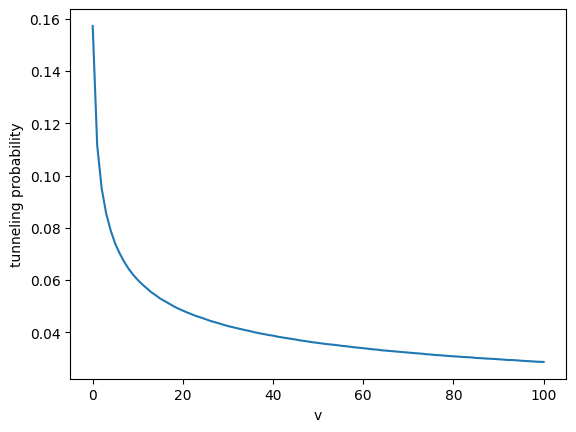

In [8]:
# energy, eigenfunctions, and turning points
P = []
for v in range (0, 101):

    # energy
    my_energy = hbar * omega * ( v + 0.5)

    # turning point E = V(x) = 1/2 k x^2 = 2 m nu^2 pi^2 x^2
    my_x = np.sqrt(my_energy / (2 * m * nu**2 * np.pi**2 ))

    # grid for integral [-x_tp:x_tp]
    x = np.arange(-my_x, my_x + 0.001, 0.001)

    # hermite polynomial
    H_v = scipy.special.hermite(v)

    # normalization constant
    N_v = ( 2**v * math.factorial(v))**(-0.5) * (alpha/np.pi)**0.25

    # wave function
    psi_v = N_v * np.exp(-alpha*x**2/2) * H_v(alpha**0.5 * x)

    # P = 1 - 2 int...
    my_P = 1.0 - np.trapz(psi_v.conj() * psi_v, x)

    P.append(my_P)

fig = plt.plot()
plt.ylabel('tunneling probability')
plt.xlabel('v')
plt.plot(P)
plt.show()

Indeed, this numerical study demonstrates that the tunneling probability decreases monotonically with increasing $v$, as expected. 

A second manifiestation of the Bohr Correspondence Principle is the evolution of the overall shape of the probability density toward the classical limit, which is [given by](https://en.wikipedia.org/wiki/Classical_probability_density)

$$\begin{align}
P = \frac{1}{\pi (x_\text{tp}^2 - x^2)^{1/2}}
\end{align}$$

The following Python code calculates the probability distribution for states with $v \le 30$ so that we can compare the quantum distribution to the classical one.

RuntimeError: Requested MovieWriter (ffmpeg) not available

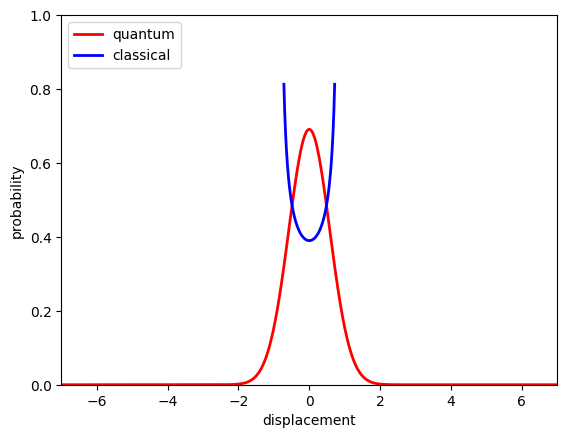

In [9]:
fig = plt.figure()

# lists of 2d line objects ... each frame will be an element in the list
line2, = plt.plot([], [], color = 'red', lw=2, label = 'quantum')
line1, = plt.plot([], [], color = 'blue', lw=2, label = 'classical')

# figure details
plt.xlim(-7, 7)
plt.ylim(0, 1)
plt.xlabel('displacement')
plt.ylabel('probability')
plt.legend(loc='upper left')

# animation function
def probability_density(v):

    # energy
    my_energy = hbar * omega * ( v + 0.5)

    # turning point E = V(x) = 1/2 k x^2 = 2 m nu^2 pi^2 x^2
    my_x_tp = np.sqrt(my_energy / (2 * m * nu**2 * np.pi**2 ))

    # grid [-x_tp:x_tp]
    x_classical = np.linspace(-my_x_tp+0.1, my_x_tp-0.1, 5000, dtype = np.float64)

    # grid [-7:7]
    x_quantum = np.linspace(-7, 7, 5000, dtype = np.float64)

    # hermite polynomial
    H_v = scipy.special.hermite(v)

    # normalization constant
    N_v = ( 2**v * math.factorial(v))**(-0.5) * (alpha/np.pi)**0.25

    # wave function
    psi_v = N_v * np.exp(-alpha*x_quantum**2/2) * H_v(alpha**0.5 * x_quantum)
    P_quantum = psi_v.conj() * psi_v

    # P = 1/(pi * sqrt(xtp^2 - x^2))
    P_classical = 1.0 / ( np.pi * np.sqrt(my_x_tp**2 - x_classical**2))

    P.append(my_P)

    line1.set_data(x_classical, P_classical)
    line2.set_data(x_quantum, P_quantum)
    
    return (line1, line2)

from matplotlib import animation

anim = animation.FuncAnimation(fig, probability_density, frames=31, interval=300, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### Selection Rules

The QHO model is a model for molecular vibrations. As such, we can use it to predict not only vibrational energy levels, but also spectra. Specifically, we can predict which transitions are "allowed" or "forbidden" based on selection rules that can be derived mathematically. 

#### Fermi's Golden Rule

Fermi's Golden Rule is a result derived from time-dependent perturbation theory that allows us to predict the probability that a system will transition between energy states $\psi_i$ and $\psi_f$ when interacting with a time-dependent external perturbation, which is represented by the operator, $\hat{H}^\prime.$ If the perturbation has some angular frequency component, $\omega$, that is consistent with the energy difference between states $\psi_i$ and $\psi_f$, $\hbar \omega$, then the probability of observing a transition between these states is proportional to the square modulus of an integral involving these states and the perturbation operator:

$$ \begin{align}
P_{i\to f} \propto |\langle \psi_i | \hat{H}^\prime | \psi_f \rangle |^2
\end{align}$$


For light-mediated transitions, the perturbing operator is

$$\begin{align}
\hat{H}^\prime = \vec{\epsilon}(t) \cdot \hat{\mu}
\end{align}$$

where $\vec{\epsilon}(t)$ is the complex amplitude of a time-dependent electric field, and $\hat{\mu}$ represents the dipole operator for the system.  These quantities are both vector quantities:

$$\begin{align}
\vec{\epsilon}(t) &= \epsilon_x \vec{i} + \epsilon_y \vec{j} + \epsilon_z\vec{k} \\
\hat{\mu} &= \hat{\mu}_x \vec{i} + \hat{\mu}_y \vec{j} + \hat{\mu}_z\vec{k}\\
\end{align}$$

where $\vec{i},$ $\vec{j},$ and $\vec{k}$ are the unit vectors in the $x,$ $y,$ and $z$ directions, respectively.

For this perturbation, the transition probability is

$$ \begin{align}
P_{i\to f} \propto |\langle \psi_i | \vec{\epsilon}(t)\cdot \hat{\mu}|\psi_f \rangle |^2
\end{align}$$

If the light is polarized in the $x$ direction, then $\epsilon_y = \epsilon_z = 0,$ and this probability simplifies to 

$$\begin{align}
P_{i\to f} \propto |\epsilon_x|^2 |\langle \psi_i | \hat{\mu}_x |\psi_f \rangle |^2
\end{align}$$

The quantity, $\langle \psi_i | \hat{\mu}_x |\psi_f \rangle,$ is referred to as a "transition dipole" matrix element. The dependence of the transition probability on this quantity is related to the fact that, in order for the system to interact with an external electric field, it must exhibit a change in its dipole moment, at least transitorily. Note that the transition probability is also proportional to $|\epsilon_x|^2$, which, itself, is proportional to the intensity of the light. Hence, the transition probability increases with increased intensity. 

#### Fermi's Golden Rule for Molecular Vibrations

Consider a vibrational mode in a molecular system that is modeled as a harmonic oscillator. For simplicity, let consider only a diatomic molecule. As discussed in the next section, vibrations in such a molecule can be described by the one-dimensional QHO model. Given the solutions to the Schrödinger equation derived above, we can use Fermi's Golden Rule to examine light-mediated transitions between vibrational states, $v$ and $v^\prime$. Assuming that the frequency-matching condition is met by the external perturbation, we have

$$ \begin{align}
P_{v \to v^\prime} \propto | \langle \psi_{v^\prime}| \hat{\mu}_x | \psi_v \rangle|^2 
\end{align}$$

The dipole operator is proportional to the displacement coordinate, $x$, so we really only need to consider

$$ \begin{align}
P_{v \to v^\prime} \propto | \langle \psi_{v^\prime}| x | \psi_v \rangle|^2 
\end{align}$$

Now, recall that the QHO wave functions have the form 

$$\begin{align}
\psi_v(x) = N_v e^{-\alpha x^2/2} H_v(\alpha^{1/2} x)
\end{align}$$

with

$$ \begin{align}
N_v = (2^v v!)^{-1/2} \left ( \frac{\alpha}{\pi}\right )^{1/4}
\end{align}$$

Given states of these form, what are the selection rules? In other words, for what $v$ and $v^\prime$ is the integral $\langle \psi_{v^\prime}| x | \psi_v \rangle,$ and, thus, $P_{v\to v^\prime}$, nonzero? We can answer that question relatively easily with the following two properties:

1. **Orthonormality**: Normalized QHO eigenfunctions form an orthonormal set:
   $$ \begin{align}
   \langle \psi_{v^\prime} (x) | \psi_{v}(x) \rangle = \delta_{vv^\prime}
   \end{align}$$

2. **Recursion Relations**: Hermite polynomials satisfy the following recursion relations:
   $$ \begin{align}
   z H_n(z) = nH_{n-1}(z) + \frac{1}{2}H_{n+1}(z)
   \end{align}$$

Consider the matrix element

$$\begin{align}
\langle \psi_{v^\prime} | x | \psi_v \rangle = N_{v^\prime} N_v \int_{-\infty}^\infty e^{-\alpha x^2} H_{v^\prime}(\alpha^{1/2}x) x H_v(\alpha^{1/2}x) dx
\end{align}$$

We use a change of variables such that

$$\begin{align}
z &= \alpha^{1/2} x \\
x &= \alpha^{-1/2} z \\
dx &= \alpha^{-1/2} dz
\end{align}$$

to give 

$$\begin{align}
\langle \psi_{v^\prime} | x | \psi_v \rangle = N_{v^\prime} N_v \frac{1}{\alpha} \int_{-\infty}^\infty e^{-z^2} H_{v^\prime}(z) z H_v(z) dz
\end{align}$$

Now, the recursion relations for the Hermite polynomials say

$$ \begin{align}
z H_v(z) = v H_{v-1}(z) + \frac{1}{2} H_{v+1}(z)
\end{align}$$

As such, we split the matrix element into two terms

$$\begin{align}
\langle \psi_{v^\prime} | x | \psi_v \rangle = N_{v^\prime} N_v \frac{1}{\alpha} \left [ v \int_{-\infty}^\infty e^{-z^2} H_{v^\prime}(z) H_{v-1}(z) dz + \frac{1}{2} \int_{-\infty}^\infty e^{-z^2} H_{v^\prime}(z) H_{v+1}(z) dz \right ] 
\end{align}$$

These integrals are proportional to overlaps between QHO wave functions, i.e.,

$$\begin{align}
\int_{-\infty}^\infty e^{-z^2} H_{v^\prime}(z) H_{v-1}(z) dz \propto \langle \psi_{v^\prime}|\psi_{v-1}\rangle = \delta_{v^\prime(v-1)}
\end{align}$$
and
$$\begin{align}
\int_{-\infty}^\infty e^{-z^2} H_{v^\prime}(z) H_{v+1}(z) dz \propto \langle \psi_{v^\prime}|\psi_{v-1}\rangle = \delta_{v^\prime(v+1)}
\end{align}$$

which implies that 

$$ \begin{align}
P_{v \to v^\prime} \propto | A \delta_{v^\prime(v-1)} + B \delta_{v^\prime(v+1)} |^2 
\end{align}$$

where $A$ and $B$ are constants. In order for $P_{v \to v^\prime}$ to be nonzero, we must have either

$$ \begin{align}
v^\prime = v - 1 
\end{align}$$

or 

$$ \begin{align}
v^\prime = v + 1
\end{align}$$

In order words, the change in the vibrational quantum number $\Delta v = v^\prime - v$ must be 

$$\begin{align}
\Delta v = \pm 1
\end{align}$$

This analysis indicates that, for a QHO, the only allowed transitions are between adjacent energy levels. 


Now, we note that we can arrive at part of the selection rule story by considering only the symmetry of the wave functions. Recall that QHO wave functions can have either even or odd symmetry, based on the symmetry of the Hermite polynomials. For even $v$, the wave functions are even in the displacement coordinate. For odd $v$, the wave functions have odd symmetry. The matrix element that determines whether a vibrational transition is allowed or forbidden is $\langle \psi_{v^\prime} | x | \psi_v \rangle$. This integral will only be non-zero if the products of the symmetries of $\psi_{v^\prime},$ $\psi_{v},$ and the operator, $x,$ is even. Because $x$ is odd, the products of the symmetries of $\psi_{v^\prime}$ and $\psi_{v}$ must be odd. This condition is consistent with but weaker than the condition derived above.

Before moving on, we note that, in addition to the $\Delta v = \pm 1$ selection rule, there are other, more physical rules that apply to different types of vibrational spectroscopy. For IR spectroscopy, transitions will only be observed for vibrational modes that result in a change in the dipole moment of the molecule (called "IR active" modes). We can rationalize this rule by recognizing that the molecule interacts with an electric field through its dipole moment. If the dipole moment does not change with the vibration, then an oscillating electric field cannot couple to that particular vibrational mode. For Raman spectroscopy, the selection rule is different. "Raman-active" vibrational modes result in a change in the polarizability of the molecule.

## Connections to Computational Chemistry

### Harmonic Frequency Analysis

Many quantum chemistry packages support vibrational analyses on molecular systems that yield both vibrational energies and the normal modes, which are the independent vibrational modes for the molecule. Linear and non-linear molecules possess $3N-5$ and $3N-6$ vibrational degrees of freedom, respectively, where $N$ is the number of atoms. Each of the normal modes can be treated as an independent quantum harmonic oscillator, the energy of which is the same as that derived above. As such, the total vibrational energy is

$$\begin{align}
E_\text{vib} = \sum_i h \nu_i ( v_i + 1/2 )
\end{align}$$

where $\nu_i$ is the frequency for the $i$th normal mode. At zero kelvin, only the $v_i=0$ state is populated for each of these modes, so the total zero-point energy is

$$\begin{align}
E_\text{ZPE} = \frac{1}{2} \sum_i h \nu_i
\end{align}$$

The harmonic vibrational frequencies can be determined using the method of [F and G matrices](https://en.wikipedia.org/wiki/GF_method), for example. Let us consider the simplest case, a heteronuclear diatomic molecule, $H_2$. As discussed above, one can calculate the potential energy curve as a function of the H-H distance using a quantum chemistry method such as Hartree-Fock theory. The potential near the equilibrium geometry can then be approximated with a harmonic one, where the force constant is defined by the second derivative of the calculated potential. Here is the same Python code used above to visualize the calculated and harmonic potentials.

In [ ]:
# redefine x because it has been over written
dx = 0.05
x = np.arange(0.4, 3.05, dx)

# equilbirum bond length
idx = np.argmin(hf_potential)
x_e = x[idx]

# k = d^2 V(x) / dx^2
k = (hf_potential[idx+1] - 2.0 * hf_potential[idx] + hf_potential[idx-1]) / dx**2

# harmonic potential
harmonic = 0.5 * k * (x-x_e)**2

plt.figure()
plt.plot(x, hf_potential, label='Hartree-Fock')
plt.plot(x, harmonic, label='harmonic')
plt.xlim(x[0], x[-1])
plt.ylim(0, 0.2)
plt.ylabel('potential')
plt.xlabel('H-H distance')
plt.legend()
plt.show()

Now, we can write down a Hamiltonian for the nuclei that experience this potential:

$$ \begin{align}
\hat{H} = -\frac{\hbar^2}{2 m_1}\frac{d^2}{dx_1^2} -\frac{\hbar^2}{2 m_2}\frac{d^2}{dx_2^2} + \frac{1}{2}k (x_2 - x_1 - x_e)^2
\end{align}$$

where $m_1$ and $m_2$ represent the masses of hydrogen atoms 1 and 2, respectively, and $x_1$ and $x_2$ represent the respective coordinates. This Hamiltonian depends on the coordinates of two particles, but through a coordinate transformation, it can be re-expressed as a sum of Hamiltonians, one representing the translational motion of the entire molecule and the other representing internal motion. We are concerned only with the internal (vibrational) motion, and the relevant Hamiltonian is

$$ \begin{align}
\hat{H} = -\frac{\hbar^2}{2 \mu}\frac{d^2}{dx^2} + \frac{1}{2}k (x - x_e)^2
\end{align}$$

where $x = x_2 - x_1$ and $\mu$ is the reduced mass

$$\begin{align}
\mu = \frac{m_1 m_2}{m_1 + m_2}
\end{align}$$

This Hamiltonian resembles the QHO Hamiltonian for an effective particle of mass, $\mu$. As such, we can apply the QHO model directly to this Hamiltonian, and the vibrational frequency should be

$$\begin{align}
\nu = \frac{1}{2\pi} \left ( \frac{k}{\mu} \right )^{1/2}
\end{align}$$

We can determine $\nu$ using the value for $k$ extracted from the Hartree-Fock potential energy curve. We must be careful of our units, though. Having calculated $k$ as the second derivative of the potential, its units are $E_h / Å^2$, where $E_h$ represents the Hartree, the atomic unit for energy. Calculating $\nu$ is probabaly easiest done in atomic units, where 1 Å = 1.8897259886 a$_0$, where a$_0$ is the Bohr, the atomic unit of distance.

In [ ]:
# mass of hydrogen (amu). take from molecule object defined earlier
m = mol.mass(0)

# convert the mass to atomic units
m = m / psi4.constants.au2amu

# reduced mass mm/(m+m) = 1/2 m
mu = 0.5 * m

# force constant in atomic units
k_au = k * psi4.constants.bohr2angstroms**2

# frequency in atomic units
nu_au = 1.0 / (2.0 * np.pi) * np.sqrt(k_au / mu)

# angular frequency (units of Hartree ... for ease of conversion to cm^-1)
omega_au = nu_au * 2.0 * np.pi 

# frequency in cm^-1
nu = omega_au * psi4.constants.hartree2wavenumbers

print('The harmonic frequency is %8.1f cm^-1' % (nu) )

Now, let us check this result against a frequency calculation carried out using Psi4. When performing frequency analysis with a quantum chemistry package such as Psi4, we must be sure that the analysis is done at the equilibrium geometry for the molecule. 

In [ ]:
# set molecule
mol = psi4.geometry("""
h
h 1 0.7
symmetry c1
""")   

# set some options for psi4
psi4.set_options({'basis': 'cc-pvdz',
                  'guess_mix': True,
                  'reference': 'uhf'})

# tell psi4 not to print any output to the screen
psi4.core.be_quiet()

# optimize geometry
psi4.optimize('scf')

# calculate harmonic frequencies
en, wfn = psi4.frequency('scf', return_wfn = True)

# extract frequencies from the wave function
freq = np.asarray(wfn.frequencies())
print('The harmonic frequency is %8.1f cm^-1' % (freq[0]) )

Our calculated value for $\nu$ agrees reasonably well with that extracted from Psi4. The small differences could stem from two sources. First, we have evaluated the second derivative of the potential numerically, whereas Psi4 has evaluated the second derivative analytically. Second, we only estimated the equilibrium position from a potential energy scan with a resolution of only 0.05 Å, whereas Psi4 determined the equilibrium position from a geometry optimization with a much tighter resolution. Nonetheless, the two values agree quite well.

### Transition State Optimization

In addition to frequency information, vibrational analysis can be used to confirm whether a stationary point that has been identified via a geometry optimization is a minimum in all of the coordinates, a transition state, or some other high-order saddle point. Each of these cases can be differentiated by the number of **imaginary** frequencies that result from the vibrational analysis. Recall that the harmonic frequency is related to the square root of the second derivative of the potential along one of the normal modes. If the potential is a minimum along this coordinate, then the second derivative is positive, and the frequency is real (because the square root of a positive number is real-valued). If the potential is a maximum along this coordinate, then the second derivative is negative, and the frequency is imaginary (because the square root of a negative number is imaginary). Hence, if all of the frequencies obtained from the vibrational analysis are real, then the molecule is at a minimum all of coordinates. If there exists one and only one imaginary frequency, then the molecule is at a transition state. If there are multiple imaginary fruequencies, then the molecule is at some high-order saddle point that is not a transition state. 

Consider the following simple isomerization reaction:

$$\begin{align}
\text{HCN} \longleftrightarrow \text{HNC} \nonumber
\end{align}$$

The transition state for this reaction should be found at an H-C-N bond angle of roughly 70$\degree$. The following code will identify this transition state and perform a frequency analysis on the optimized structure.

In [ ]:
# set molecule
mol = psi4.geometry("""
h
c 1 1.2
n 2 1.2 1 70.0
symmetry c1
""")   

# set some options for psi4. 
# don't forget to specify the transition state search
psi4.set_options({'basis': 'cc-pvdz',
                  'guess_mix': True,
                  'reference': 'uhf',
                  'opt_type': 'ts'})

# tell psi4 not to print any output to the screen
psi4.core.be_quiet()

# optimize geometry
psi4.optimize('scf')

# calculate harmonic frequencies
en, wfn = psi4.frequency('scf', return_wfn = True)

# extract frequencies from the wave function
freq = np.asarray(wfn.frequencies())
for i in range(len(freq)):
    print('The harmonic frequency for mode %i is %8.1f cm^-1' % (i, freq[i]) )

Note that, when the frequencies are extracted from Psi4, the imaginary frequency actually appears as a negative number. This convention is used in other quantum chemistry packages as well. Since there is one and only one imaginary/negative frequency, we can conclude that the geometry optimization has identified a transition state.

## Additional Considerations

### Boltzmann Distribution

The probability that a vibrational state is populated at temperature, $T$, is governed by the [Boltzmann distribution](https://en.wikipedia.org/wiki/Boltzmann_distribution):

$$\begin{align}
\rho_i = \frac{e^{-E_i/kT}}{\sum_j e^{-E_j/kT}}
\end{align}$$

Where $E_i$ is the energy of the state, $k$ is the Boltzmann constant, and the term in the denominator is the canonical partition function. The relative populations of two states is given by

$$\begin{align}
\frac{\rho_i}{\rho_j} = e^{-(E_i-E_j)/kT}
\end{align}$$

Obviously, the relative populations depend on the temperature. The populations also depend on how closely-spaced the energy levels are. Recall that $\nu = \frac{1}{2\pi}\left ( \frac{k}{\mu} \right )$. As such, if $\mu$ is small (e.g., H$_2$, HCl), then the spacing between levels will be large, and, at room temperature, the $v=0$ state will be the most populated. On the other hand, if $\mu$ is large (e.g., I$_2$), the spacing between levels is much smaller, and other vibrational states may become thermally accessible.

At low temperatures, the principal absorption band in a vibrational spectrum will correspond to the $v=0 \to v=1$ transition. Depending on the temperature, the spectrum may also include **hot bands** corresponding to transitions from higher-energy vibrational states (e.g., $v=1 \to v=2$, etc.). 


### "Real" Molecular Vibrations

The QHO model is just that, a model, and the vibrational motion of a real molecule is not perfectly described as a QHO. Several key differences between vibrations in a harmonic oscillator and a "real" molecule are worth discussing.

1. In addition to transitions that obey the selection rule, $\Delta v = \pm 1,$ a vibrational spectrum may also include **overtones**, which correspond to transitions that violate this rule (e.g., $v=0 \to v=2$). Why are such features observed, if, mathematically, the selection rule suggests that these transitions should not occur? The reason is that the actual potential energy curve corresponding to a vibrational mode is not harmonic. As such, the selection rules derived above are not strict.

2. The energy levels of a quantum harmonic oscillator are evenly spaced. On the other hand, vibrational energy levels in a real molecule become more closely spaced as the vibrational quantum number increases. Hence, the QHO model is better suited to the description of low-energy vibrational states than high-energy ones.
   
3. The QHO model predicts that there are infinitely many **bound** vibrational states, with quantized energies. In a real-molecular system, however, the vibrational energy levels get closer together with increasing energy until reaching the dissociation limit for the molecule. Beyond this point, there exists a continuum of **unbound** states. 
